In [17]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!7z x '10.10_my_data.7z'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1729791 bytes (1690 KiB)

Extracting archive: 10.10_my_data.7z
--
Path = 10.10_my_data.7z
Type = 7z
Physical Size = 1729791
Headers Size = 375
Method = LZMA2:21
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./my_data/1.jpg
  Size:     136959 bytes (134 KiB)
  Modified: 2019-08-26 11:39:58
with the file from archive:
  Path:     my_data/1.jpg
  Size:     136959 bytes (134 KiB)
  Modified: 2019-08-26 11:39:58
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? y

 60% 1 - my_data/1.jpg                      
Would you like to replace the existing file:
  Path:     ./my_data/2.jpg
  Size:     159407 bytes (156 

In [71]:
import cv2, time, os, tensorflow as tf
import numpy as np
from tensorflow.python.keras.utils.data_utils import get_file
from google.colab.patches import cv2_imshow

In [72]:
np.random.seed(123)

In [78]:
class Detector:
  def __init__(self):
    pass

  #чтение классов из файла coco.names и создание списка классов classesList
  def readClasses(self, classesFilePath):
    with open(classesFilePath, 'r') as f:
      self.classesList = f.read().splitlines()

    #для каждой метки класса создадим цвет
    #Colors list
    self.colorsList = np.random.uniform(low=0, high=255, size=(len(self.classesList), 3))

    #проверка на совпадение кол-ва цветов и классов
    if len(self.colorsList) != len(self.classesList):
      print(f'Count colors: {len(self.colorsList)}, Count classes: {len(self.classesList)}')
    else:
      print('Read classes was completed succesfully!')


  #функция загрузки модели с github
  def downloadModel(self, modelURL):
    
    fileName = os.path.basename(modelURL)
    self.modelName = fileName[:fileName.index('.')]

    self.cacheDir = './pretrainded_models'  #кэш каталог куда будет загружена модель
    os.makedirs(self.cacheDir, exist_ok=True)

    #функция для получения файлов/ extract - создаст нужные папки
    get_file(
        fname=fileName,
        origin=modelURL,
        cache_dir=self.cacheDir,
        cache_subdir='checkpoints',
        extract=True
    )


  #нарисуем предсказанные bb
  def createBoundingBox(self, image, threshold=0.5):
    inputTensor = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    inputTensor = tf.convert_to_tensor(inputTensor, dtype=tf.uint8)
    inputTensor = inputTensor[tf.newaxis, ...]

    detections = self.model(inputTensor)

    bboxs = detections['detection_boxes'][0].numpy()
    classIndexes = detections['detection_classes'][0].numpy().astype(np.int32)
    classScores = detections['detection_scores'][0].numpy()

    imH, imW, imC = image.shape

    bboxIdx = tf.image.non_max_suppression(bboxs, classScores, max_output_size=50, iou_threshold=treshold, score_threshold=treshold)

    if len(bboxIdx) != 0:
      for i in bboxIdx:
        bbox = tuple(bboxs[i].tolist())
        classConfidence = round(100*classScores[i])
        classIndex = classIndexes[i]

        classLabelText = self.classesList[classIndex]
        classColor = self.colorsList[classIndex]

        displayText = '{}: {}%'.format(classLabelText, classConfidence)

        ymin, xmin, ymax, xmax = bbox
        ymin, xmin, ymax, xmax = (ymin*imH, xmin*imW, ymax*imH, xmax*imW)
        ymin, xmin, ymax, xmax = int(ymin), int(xmin), int(ymax), int(xmax)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=classColor, thickness=1)
        cv2.putText(image, displayText, (xmin, ymin - 10), cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)

    return image



  #загрузка модели
  def loadModel(self):
    print('Model Loading ' + self.modelName)
    tf.keras.backend.clear_session()
    self.model = tf.saved_model.load(os.path.join(self.cacheDir, 'checkpoints', self.modelName, 'saved_model'))
    print('Model ' + self.modelName + ' loaded successfully...')

  # def fitModel(self):
  #   self.model.fit()


  #выведем изображение
  def predictImage(self, imagePath, treshold):
    image = cv2.imread(imagePath)

    bboxImage = self.createBoundingBox(image, treshold)

    cv2.imwrite(self.modelName + '.jpg', bboxImage)
    cv2_imshow(image)

Emulation of file run_me.py

Read classes was completed succesfully!
Model Loading ssd_mobilenet_v2_320x320_coco17_tpu-8
Model ssd_mobilenet_v2_320x320_coco17_tpu-8 loaded successfully...


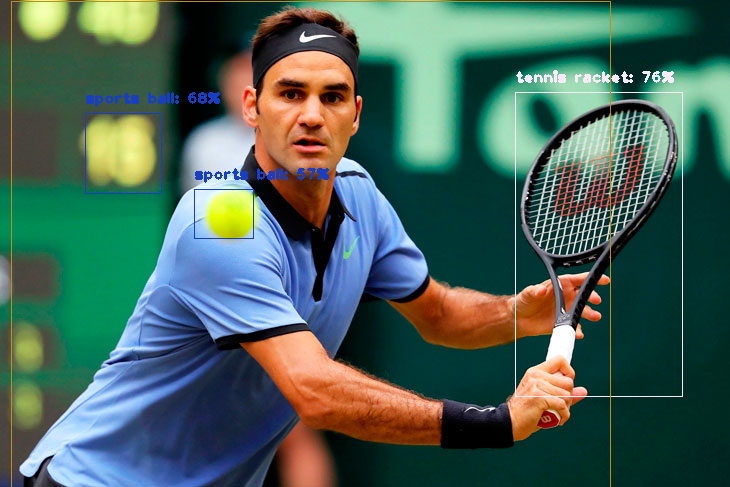

In [80]:
modelURL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz'
classFile = 'coco.names'
imagePath = 'my_data/test_coco.jpg'
treshold = 0.5

detector = Detector()
detector.readClasses(classFile)
detector.downloadModel(modelURL)
detector.loadModel()
detector.predictImage(imagePath, treshold)